In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import copy
import os
import cv2
from tqdm.notebook import tqdm
from natsort import natsorted
from glob import glob
from google.colab.patches import cv2_imshow

from skimage import img_as_float, io, color, filters, exposure, data
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma,wiener,
                                 unsupervised_wiener,richardson_lucy)
from skimage.morphology import disk
from skimage.filters import rank

from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter

<ipython-input-2-db9ea9556de7>:26: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


PSNR/SSIM Goalposts

Gaussian Blur: 20.5/0.65

Motion Blur: 21.5/0.70

Salt and Pepper noise: 26.5/0.90

Gaussian noise: 19.5/0.60

Speckle noise: 20.0/0.65

In [3]:
dirs = '/content/gdrive/MyDrive/Colab Notebooks/188/stage1_data/'
sp_noise_files = natsorted(glob(dirs + "sp_noise/*"))
clean_files = natsorted(glob(dirs + "input_imgs/*"))
gaussian_blur_files = natsorted(glob(dirs + "gaussian_blur/*"))
gaussian_noise_files = natsorted(glob(dirs + "gaussian_noise/*"))
motion_blur_files = natsorted(glob(dirs + "motion_blur/*"))
speckle_noise_files = natsorted(glob(dirs + "speckle_noise/*"))

dir_blur = '/content/gdrive/MyDrive/Colab Notebooks/188/stage1_data/gaussian_blur/'
dir_input = '/content/gdrive/MyDrive/Colab Notebooks/188/stage1_data/input_imgs/'
dir_noise = '/content/gdrive/MyDrive/Colab Notebooks/188/stage1_data/gaussian_noise/'
dir_moblur = '/content/gdrive/MyDrive/Colab Notebooks/188/stage1_data/motion_blur/'

img1str = '0000000000.png'

img1 = cv2.imread(dir_input + img1str)
img1_noise = cv2.imread(dir_noise + img1str)
img1_blur = cv2.imread(dir_blur + img1str)
img1_moblur = cv2.imread(dir_moblur + img1str)

In [4]:
def get_rgb(img):
  red = img[:,:,0]
  green = img[:,:,1]
  blue = img[:,:,2]

  return red, green, blue

In [5]:
def compute_psnr1(original, filtered):
  # Compute the PSNR between the original noisy image and the filtered image
  psnr_before = psnr(img1, original)
  psnr_after = psnr(img1, filtered)

  return psnr_after - psnr_before, psnr_before, psnr_after

In [ ]:
# ---------------Gaussian Blur-------------------
# benchmark: 26.5/0.65 (incorrect calculation)
# benchmark (updated): 20.5/0.65
# baseline: 21.146
# best: 22.18, .77

In [6]:
psnr_sum = 0
ssim_sum = 0
count = 0
kernel_size = 7

def get_psf(k=10):
  return np.ones([k,k]) / (k*k)

for noisy_file, clean_file in tqdm(zip(gaussian_blur_files, clean_files)):
  img = np.array(Image.open(clean_file))/255
  noisy_img = np.array(Image.open(noisy_file))/255

  red, green, blue = get_rgb(noisy_img)

  best = 0
  high1 = 0
  high2 = 0
  k = 5
  q = 0.15
  r = 4

  # Define the point spread function (PSF)
  psf = get_psf(k)

  red = filters.unsharp_mask(red, radius=r, amount=1)
  green = filters.unsharp_mask(green, radius=r, amount=1)
  blue = filters.unsharp_mask(blue, radius=r, amount=1)

  filt_r = wiener(red, psf, q)
  filt_g = wiener(green, psf, q)
  filt_b = wiener(blue, psf, q)

  filtered_img = np.stack([filt_r,filt_g,filt_b],axis=-1)

  psnr_sum += psnr(img,filtered_img)
  ssim_sum += ssim(img,filtered_img, multichannel=True)

  count += 1
  # print(psnr_sum/count)
  # print("\r", psnr_sum/count, end="")

print("Gaussian Blur:")
print("PSNR is: " + str(psnr_sum/count))
print("SSIM is: " + str(ssim_sum/count))

0it [00:00, ?it/s]

<ipython-input-6-3f369723fce9>:36: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_sum += ssim(img,filtered_img, multichannel=True)


Gaussian Blur:
PSNR is: 22.10805161425606
SSIM is: 0.7475697496860274


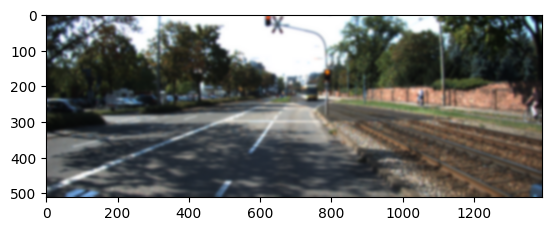

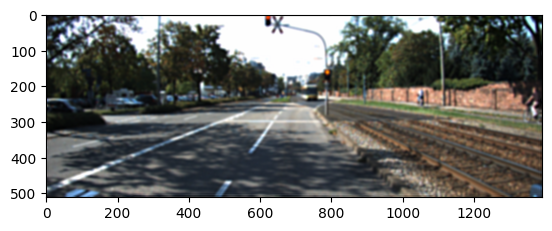

In [7]:
plt.imshow(noisy_img)
plt.show()
plt.imshow(filtered_img)
plt.show()

In [ ]:
# ---------------Gaussian Noise-------------------
# benchmark: 19.5/0.60
# baseline: 12.3/0.60
# PSNR for Gaussian Noise: 20.632023081256435
# SSIM for Gaussian Noise: 0.6097597537309719

In [9]:
# Load the image with Gaussian noise

psnr_sum = 0
ssim_sum = 0

kernel_size = 9

for noisy_file, clean_file in tqdm(zip(gaussian_noise_files,  clean_files)):
  img = np.array(Image.open(clean_file))/255.0
  noisy_img = np.array(Image.open(noisy_file))/255.0

  red, green, blue = get_rgb(noisy_img)

  filt_r = filters.median(red, selem=np.ones((kernel_size,kernel_size)))
  filt_g = filters.median(green, selem=np.ones((kernel_size,kernel_size)))
  filt_b = filters.median(blue, selem=np.ones((kernel_size,kernel_size)))

  filtered_img = np.stack([filt_r,filt_g,filt_b],axis=-1)

  psnr_sum += psnr(img,filtered_img)
  ssim_sum += ssim(img,filtered_img, multichannel=True)

print("PSNR for Gaussian Noise: " + str(psnr_sum/11))
print("SSIM for Gaussian Noise: " + str(ssim_sum/11))

0it [00:00, ?it/s]

<ipython-input-9-5e963ef04b30>:14: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_r = filters.median(red, selem=np.ones((kernel_size,kernel_size)))
<ipython-input-9-5e963ef04b30>:15: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_g = filters.median(green, selem=np.ones((kernel_size,kernel_size)))
<ipython-input-9-5e963ef04b30>:16: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_b = filters.median(blue, selem=np.ones((kernel_size,kernel_size)))
<ipython-input-9-5e963ef04b30>:21: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_sum += ssim(img,filtered_img, multichannel=True)


PSNR for Gaussian Noise: 20.632023081256435
SSIM for Gaussian Noise: 0.6097597537309719


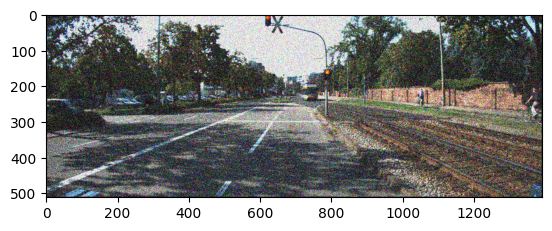

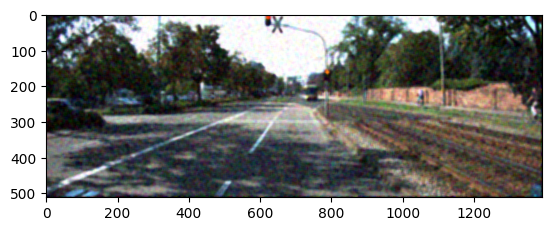

In [10]:
plt.imshow(noisy_img)
plt.show()
plt.imshow(filtered_img)
plt.show()

In [ ]:
#------------------motion blur-------------------------
# Motion Blur: 21.5/0.70

# best (average of all):
# psnr:20.100394154868276
# ssim:0.6659755463815804

0it [00:00, ?it/s]

<ipython-input-11-ee9956ece3c7>:47: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_tmp = ssim(img,filtered_img, multichannel=True)


(160, 3, 0.35) 21.684968197445144 0.7090198065742043
(160, 3, 0.25) 20.88401710254706 0.684053564484425
(160, 3, 0.28) 20.79471714258974 0.693363184521146
(160, 3, 0.3) 20.404926086888047 0.6824235318256126
(160, 3, 0.35) 20.953700937028277 0.7073896709297688
(160, 3, 0.35) 19.88351324218733 0.697979477425231
(160, 3, 0.35) 20.139125465892143 0.6833063356509648
(160, 3, 0.3) 19.932063956566413 0.6568945311388691
(160, 3, 0.35) 19.031446732092743 0.6225318959403444
(160, 3, 0.35) 18.848525886357702 0.6102695712961127
(160, 3, 0.25) 18.54733095395645 0.5784994404107057


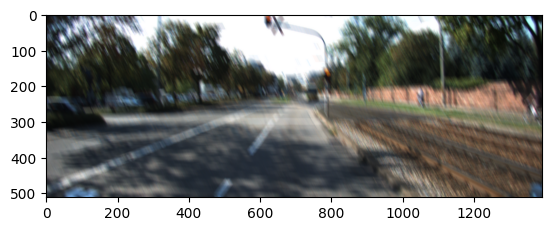

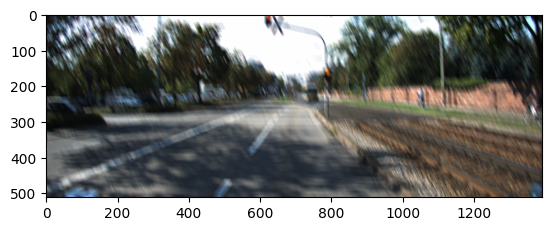

20.100394154868276
0.6659755463815804


In [11]:
psnr_sum = 0
ssim_sum = 0
count = 0

def get_psf3(k,angle):
    motion_blur_kernel = np.zeros((k, k))
    motion_blur_kernel[int((k-1)/2), :] = np.ones(k)
    rotation_matrix = cv2.getRotationMatrix2D((int((k-1)/2), int((k-1)/2)), angle, 1)
    motion_blur_kernel = cv2.warpAffine(motion_blur_kernel, rotation_matrix, (k, k))
    motion_blur_kernel /= np.sum(motion_blur_kernel)
    return motion_blur_kernel

k=3
q=0.03
r=4
angle=160

for noisy_file, clean_file in tqdm(zip(motion_blur_files, clean_files)):
  img = np.array(Image.open(clean_file))/255.0
  noisy_img = np.array(Image.open(noisy_file))/255.0

  high = 0
  high2 = 0
  best = 0
  for angle in [160]:
    for a1 in [0.28,0.25,.3,.35]:
        psf = get_psf3(k,angle)
        # psf = np.ones((k, k)) / (k*k)

        red, green, blue = get_rgb(noisy_img)

        filt_r = filters.unsharp_mask(red, radius=r, amount=1)
        filt_g = filters.unsharp_mask(green, radius=r, amount=1)
        filt_b = filters.unsharp_mask(blue, radius=r, amount=1)

        filtered_img = np.stack([filt_r,filt_g,filt_b],axis=-1)

        filt_r = wiener(red, psf, q)
        filt_g = wiener(green, psf, q)
        filt_b = wiener(blue, psf, q)

        img2 = np.stack([filt_r,filt_g,filt_b],axis=-1)

        filtered_img = cv2.addWeighted(filtered_img, a1, img2, 1-a1, 0.0)

        psnr_tmp = psnr(img,filtered_img)
        ssim_tmp = ssim(img,filtered_img, multichannel=True)
        if psnr_tmp > high:
            best = angle,k,a1
            high = psnr_tmp
            high2 = ssim_tmp

  print(best, high, high2)
  psnr_sum += high    #psnr(img,filtered_img)
  ssim_sum += high2   #ssim(img,filtered_img, multichannel=True)
  count += 1

  # print("\r", psnr_sum/count, end="")

plt.imshow(noisy_img)
plt.show()
plt.imshow(filtered_img)
plt.show()

print(psnr_sum/count)
print(ssim_sum/count)

In [ ]:
# -----------------------salt and pepper-----------------------
# Salt and Pepper noise: 26.5/0.90

# best:
# 26.765740881545096
# 0.9232724604869713

In [12]:
kernel_size = 3

psnr_sum = 0
ssim_sum = 0
count=0

for noisy_file, clean_file in tqdm(zip(sp_noise_files,  clean_files)):
  img = np.array(Image.open(clean_file))/255.0
  noisy_img = np.array(Image.open(noisy_file))/255.0

  red = noisy_img[:,:,0]
  green = noisy_img[:,:,1]
  blue = noisy_img[:,:,2]

  filt_r = filters.median(red, selem=np.ones((kernel_size,kernel_size)))
  filt_g = filters.median(green, selem=np.ones((kernel_size,kernel_size)))
  filt_b = filters.median(blue, selem=np.ones((kernel_size,kernel_size)))

  filtered_img = np.stack([filt_r,filt_g,filt_b],axis=-1)

  psnr_sum += psnr(filtered_img,img)
  ssim_sum += ssim(img,filtered_img, multichannel=True)
  count+=1

print(psnr_sum/count)
print(ssim_sum/count)

0it [00:00, ?it/s]

<ipython-input-12-00fd1d4b6b2c>:15: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_r = filters.median(red, selem=np.ones((kernel_size,kernel_size)))
<ipython-input-12-00fd1d4b6b2c>:16: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_g = filters.median(green, selem=np.ones((kernel_size,kernel_size)))
<ipython-input-12-00fd1d4b6b2c>:17: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_b = filters.median(blue, selem=np.ones((kernel_size,kernel_size)))
<ipython-input-12-00fd1d4b6b2c>:22: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_sum += ssim(img,filtered_img, multichannel=True)


26.765740881545096
0.9232724604869713


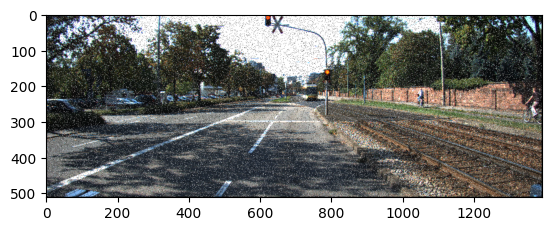

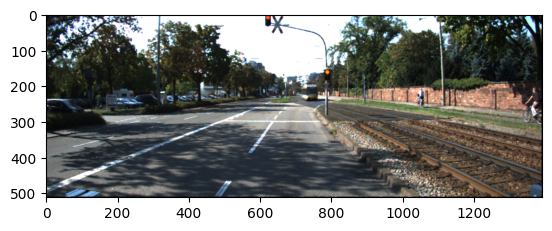

In [13]:
plt.imshow(noisy_img)
plt.show()
plt.imshow(filtered_img)
plt.show()

In [8]:
# -------------------- speckle noise ---------------------

# benchmark: 20.0/0.65

# best:
# psnr: 23.285522043967152
# ssim: 0.766648529888215

In [14]:
psnr_sum=0
ssim_sum=0
count=0
k=3

for noisy_file, clean_file in tqdm(zip(speckle_noise_files,  clean_files)):
  img = np.array(Image.open(clean_file))/255.0
  noisy_img = np.array(Image.open(noisy_file))/255.0

  red,green,blue = get_rgb(noisy_img)

  filt_r = filters.median(red, selem=np.ones((k,k)))
  filt_g = filters.median(green, selem=np.ones((k,k)))
  filt_b = filters.median(blue, selem=np.ones((k,k)))

  filtered_img = np.stack([filt_r,filt_g,filt_b],axis=-1)

  psnr_sum += psnr(img,filtered_img)
  ssim_sum += ssim(img,filtered_img, multichannel=True)
  count+=1

print(psnr_sum/count)
print(ssim_sum/count)

0it [00:00, ?it/s]

<ipython-input-14-7afc412571fe>:12: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_r = filters.median(red, selem=np.ones((k,k)))
<ipython-input-14-7afc412571fe>:13: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_g = filters.median(green, selem=np.ones((k,k)))
<ipython-input-14-7afc412571fe>:14: FutureWarning: `selem` is a deprecated argument name for `median`. It will be removed in version 1.0. Please use `footprint` instead.
  filt_b = filters.median(blue, selem=np.ones((k,k)))
<ipython-input-14-7afc412571fe>:19: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_sum += ssim(img,filtered_img, multichannel=True)


23.285522043967152
0.766648529888215


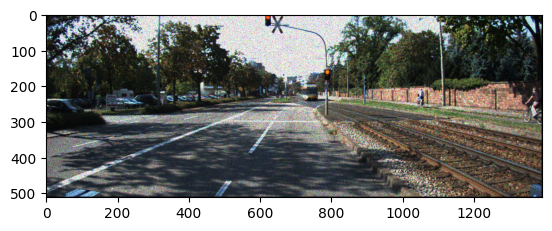

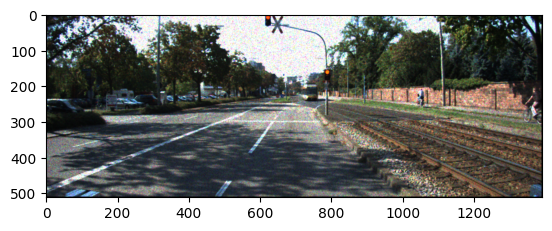

In [15]:
plt.imshow(noisy_img)
plt.show()
plt.imshow(filtered_img)
plt.show()